In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from meshparty import skeleton, skeleton_io
import seaborn as sns
from cloudfiles import CloudFiles
import io
from meshparty import meshwork
import nglui 
from caveclient import CAVEclient


In [2]:
# pull out neurons that are proofread into a df
skeleton_manifest = pd.read_feather('/Users/emily.joyce/Work/helping_op/Olga/em_connectomics_mesh_skeletons_directory_proof_status.feather')
proofread_skels = skeleton_manifest[(~pd.isna(skeleton_manifest['status_dendrite'])) | (~pd.isna(skeleton_manifest['status_axon']))].reset_index()


In [3]:
#various google cloud paths 

#raw skeleton files
skel_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups/'

# upright
upright_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/upright/BIL_excitatory/'

# layer aligned
layer_aligned_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/layer_align/BIL_excitatory/'


# polygon files (layer bounds for each cell)
# gives 2d shape for each layer 
layer_bounds_path = 'https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/poly_files/BIL_polys/'

# average layer bounds from IVSCC (to which layer aligned celled are alligned)
# this just gives a single value for each layer (straight line)
layer_bounds_average_path = "https://storage.googleapis.com/allen-minnie-phase3/minniephase3-emily_skeleton_keys/avg_layer_depths/"

# mesh path with gs://
mw_path = 'gs://allen-minnie-phase3/minniephase3-emily-pcg-skeletons/minnie_all/BIL_neurons/file_groups/'



In [4]:
# functions that will pull out skeletons and visualize 


SWC_COLUMNS = ('id', 'type', 'x', 'y', 'z', 'radius', 'parent',)
COLUMN_CASTS = {
    'id': int,
    'parent': int,
    'type': int
}


def read_layer_depths(cloudpath, soma_id = None, filename = 'mouse_me_and_met_avg_layer_depths.json'):
    '''
    if you do not pass a soma id, it will load the average layer bounds file 
    '''
    if not soma_id is None:
        filename = f'{soma_id}_poly.json'

    cf = CloudFiles(cloudpath)
    return cf.get_json(filename)


def plot_layers(ax, cloudpath, soma_id = None):
    '''
    
    If you do not pass a soma id, it will plot the average layer bounds file. otherwise pass 
    soma id to plot the neuron and the custom layer bounds for that neuron
    '''
    
    layer_file = read_layer_depths(cloudpath, soma_id)
    
    # calculate x min and max on ax 
    xmin, xmax = ax.get_xlim()
    
    if soma_id == None:
        layer_file = np.array(list(layer_file.values()))*-1
        
        [ax.hlines(y_val, xmin = xmin, xmax = xmax) for y_val in layer_file]

    else:
        for key in layer_file.keys():
            if key == 'layer_polygons':

                for layer in layer_file[key]:
                    bound = np.array(layer['path'])
                    ax.scatter(bound[:,0]*0.3603, bound[:,1]*0.3603, s = 1)

            else:
                bound = np.array(layer_file[key]['path'])
            ax.scatter(bound[:,0]*0.3603, bound[:,1]*0.3603, s = 1)
    


def apply_casts(df, casts):

    for key, typ in casts.items():
        df[key] = df[key].astype(typ)

    

def read_skeleton(root_id, nuc_id, cloud_path = skel_path, 
                 df = None):
    if cloud_path == skel_path:
        file_path = cloud_path + f"{root_id}_{nuc_id}/{root_id}_{nuc_id}.swc"
    elif cloud_path == upright_path or cloud_path == layer_aligned_path:
        file_path = cloud_path + f"{nuc_id}.swc"
    #print(file_path)
    df = read_swc(file_path)
    if not all(df.index == df['id']):
        # remap id and parent to index to 
        id_map = dict(zip(df['id'], df.index))
        id_map[-1] = -1
        df['id'] = [id_map[x] for x in df['id']]
        df['parent'] = [id_map[x] for x in df['parent']]
        
        
    verts = df[['x','y','z']].values
    edges = df[['id','parent']].iloc[1:].values
    sk=skeleton.Skeleton(verts, edges, vertex_properties={'radius':df['radius'], 
                                                       'compartment':df['type']})
    return sk


def read_swc(path, columns=SWC_COLUMNS, sep=' ', casts=COLUMN_CASTS):

    """ Read an swc file into a pandas dataframe
    """
    if "://" not in path:
        path = "file://" + path

    #cloudpath, file = os.path.split(path)
    #cf = CloudFiles(cloudpath)
    #path = io.BytesIO(cf.get(file))
    
    df = pd.read_csv(path, names=columns, comment='#', sep=sep)
    apply_casts(df, casts)
    return df

def path_to_skel(path):
    df = read_swc(path)
    verts = df[['x','y','z']].values
    verts = verts-1
    edges = df[['id','parent']].iloc[1:].values
    print(len(verts),len(edges))
    sk=skeleton.Skeleton(verts, edges, vertex_properties={'radius':df['radius'], 
                                                       'compartment':df['type']})
    return sk

def plot_cell(ax, sk, title='', invert_ax = True):

    
    #ax.set_ylim(1100, 300)
    
    MORPH_COLORS = {3: "firebrick", 4: "salmon", 2: "steelblue"}
    if min(sk.vertices[:,1]) < 0:    
        ax.invert_yaxis()
    for compartment, color in MORPH_COLORS.items():
        lines_x = []
        lines_y = []
        guess = None

        skn=sk.apply_mask(sk.vertex_properties['compartment']==compartment)

        for cover_path in skn.cover_paths:
            path_verts = skn.vertices[cover_path,:]
            ax.plot(path_verts[:,0], path_verts[:,1], c=color, linewidth=1)
            
        ax.set_aspect("equal")
        
    if invert_ax:
        ax.invert_yaxis()

    
    #ax.set_ylim(1100, 300)
    sns.despine(left=True, bottom=True)
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_title(title)


    
    
def load_mws_from_folder(root_id, nuc_id, folder_path = mw_path):
    
    filename = f"{root_id}_{nuc_id}/{root_id}_{nuc_id}.h5"
    
    cf = CloudFiles(folder_path)
    binary = cf.get([filename])


    with io.BytesIO(cf.get(binary[0]['path'])) as f:
        f.seek(0)
        mw = meshwork.load_meshwork(f)

    return mw

def plot_mw_skel(ax, mw, title = '', view_synapses = 'none', pre_color = 'yellowgreen', post_color = 'plum',
                view_layers = False):
    '''
    view synapses can be 'none', 'all', 'pre', 'post'
    
    '''
    
    
    MORPH_COLORS = {3: "firebrick", 4: "salmon", 2: "steelblue"}
    colors = np.ones(len(mw.skeleton.vertices))
    colors[mw.anno.basal_mesh_labels.skel_mask] = 3
    colors[mw.anno.apical_mesh_labels.skel_mask] = 4
    colors[mw.anno.is_axon.skel_mask] = 2
    
    ax.invert_yaxis()
    for compartment, color in MORPH_COLORS.items():
        lines_x = []
        lines_y = []
        guess = None

        skn=mw.skeleton.apply_mask(colors==compartment)

        for cover_path in skn.cover_paths:
            path_verts = skn.vertices[cover_path,:]
            ax.plot(path_verts[:,0], path_verts[:,1], c=color, linewidth=1)
            
        ax.set_aspect("equal")
        
    if view_synapses != 'none':
        
        if view_synapses == 'all' or view_synapses == 'pre':
            presyns = np.array([np.array(x) for x in (mw.anno.pre_syn['pre_pt_position']).values])
            ax.scatter(presyns[:,0]*4, presyns[:,1]*4, s = 2, c = pre_color)
            
        if view_synapses == 'all' or view_synapses == 'post':
            postsyns = np.array([np.array(x) for x in (mw.anno.post_syn['post_pt_position']).values])
            ax.scatter(postsyns[:,0]*4, postsyns[:,1]*4, s = 2, c = post_color)


        
    
    
    #ax.set_ylim(1100, 300)
    sns.despine(left=True, bottom=True)
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_title(title)
    
    
 


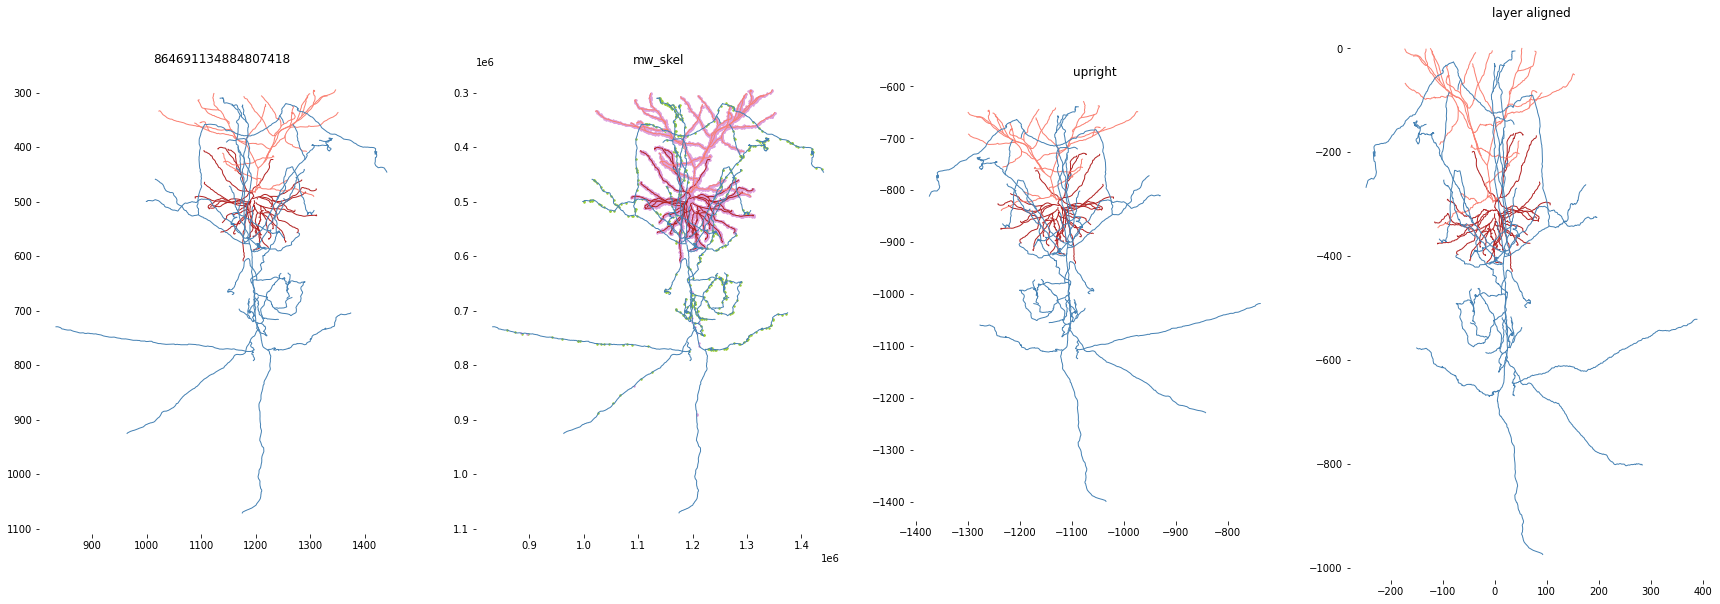

In [5]:
# Visuzlize the raw skeleton, skeleton from the meshwork with synapses, upright skeleton, layer aligned (broken) 

# visualize raw skeleton
f , ax = plt.subplots(1,4, figsize=(30,50))

row = 0

rid = proofread_skels.loc[row, 'root_id']
sid = proofread_skels.loc[row, 'soma_id']
sk = read_skeleton(rid, sid, skel_path)

plot_cell(ax[0], sk, title=rid)



# plot the skeleton with synapses from meshwork 
mw = load_mws_from_folder(rid, sid, folder_path = mw_path)
mw_skel = mw.skeleton
plot_mw_skel(ax[1], mw, 'mw_skel', view_synapses='all')


# visualize upright skel 
upright_skel = read_skeleton(rid, sid, upright_path)
plot_cell(ax[2], upright_skel, title = 'upright') 

# visualize layer aligned skel 
la_skel = read_skeleton(rid, sid, layer_aligned_path)
plot_cell(ax[3], la_skel, title = 'layer aligned') 


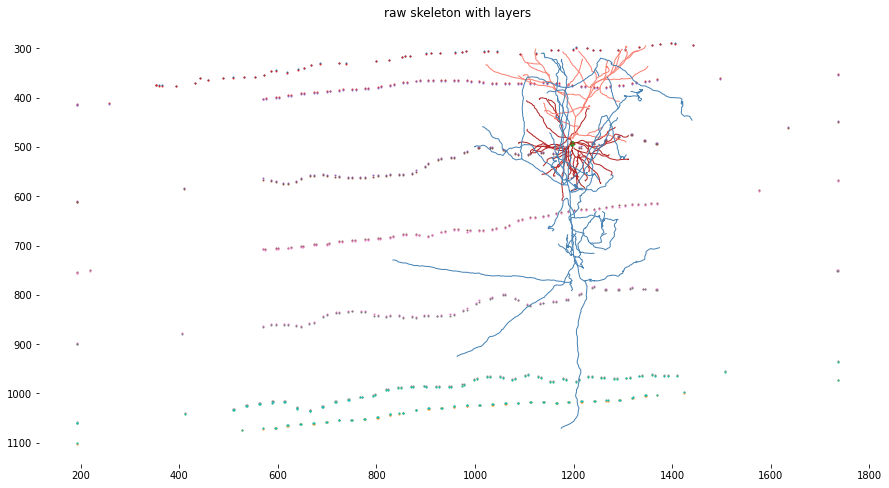

In [6]:
# plot the raw skeleton with layer bounds 
# layer 1, 2/3, 4, 5, 6a, 6b

f , ax = plt.subplots(figsize=(15,25))
plot_cell(ax, sk, title='raw skeleton with layers')
plot_layers(ax, layer_bounds_path, soma_id = sid)



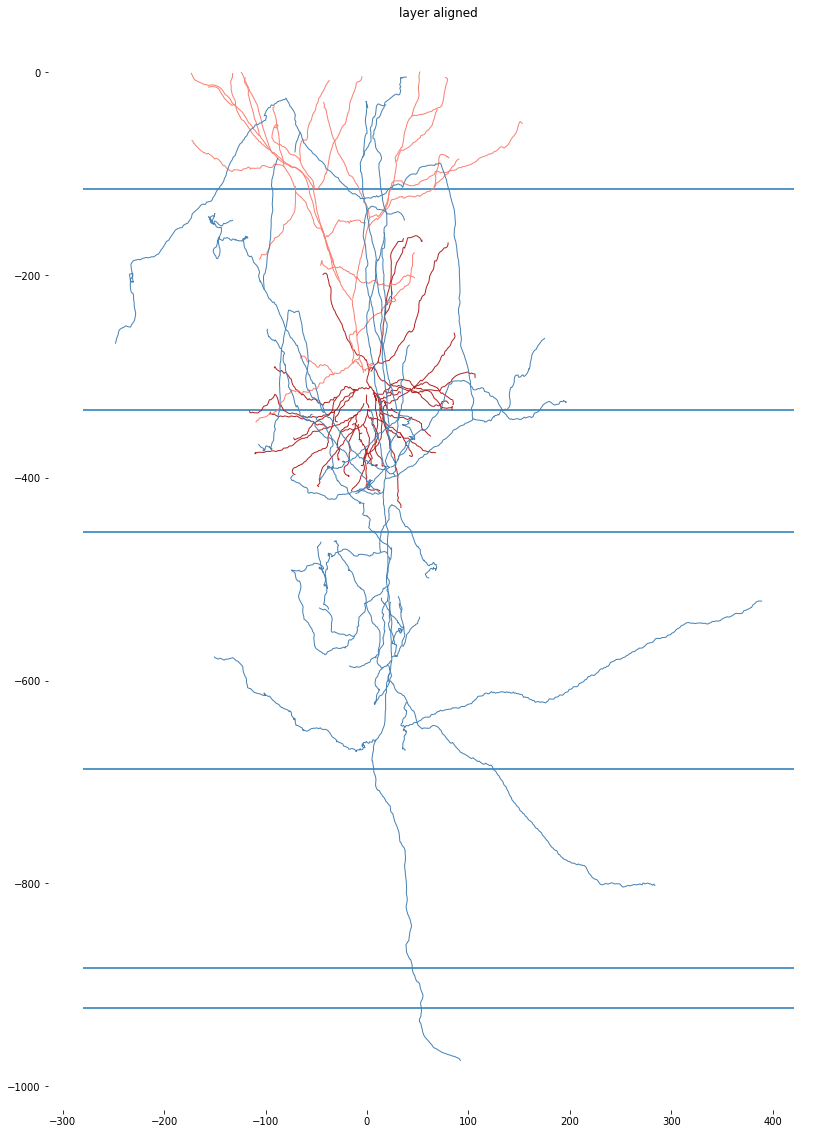

In [8]:
# plot the layer aligned cell with the average layer bounds plotted 
f , ax = plt.subplots(figsize=(15,20))
plot_cell(ax, la_skel, title = 'layer aligned') 
plot_layers(ax, layer_bounds_average_path)


In [9]:
# pull the neuron up in neuroglancer 

client = CAVEclient('minnie65_phase3_v1')
client.materialize.version = 343

nglui.statebuilder.helpers.make_neuron_neuroglancer_link(client, rid)

# !! open this link in a new tab so that you don't lose this notebook 
# right click on hyperlink, new tab

In [10]:
# looking into the widths of the branches of a skeleton
# radius is measured as an average accross the entire branch, 
# then each node in that branch is given the same radius value

# node width is stored in the SWC file and the meshwork (mw) file 

# in swc file, here we will look at the raw skeleton: 
raw_skel_path = skel_path+f'{rid}_{sid}/{rid}_{sid}.swc'
swc_df = read_swc(raw_skel_path)
swc_df

# the radius column holds radius information 


,id,type,x,y,z,radius,parent
0,0,1,1196.268,492.516,919.720,6.146,-1
1,1,3,1197.324,498.126,917.747,0.511,0
2,2,3,1197.588,499.529,917.253,0.511,1
3,3,3,1197.852,500.931,916.760,0.511,2
4,4,3,1198.116,502.334,916.267,0.511,3
...,...,...,...,...,...,...,...
9881,9881,3,1188.402,502.026,966.790,0.072,9880
9882,9882,3,1188.048,502.357,965.360,0.072,9881
9883,9883,3,1187.344,502.811,964.795,0.072,9882
9884,9884,3,1202.712,493.304,914.400,0.051,0


In [11]:
# now look at the meshwork radius information
# radius/area/volume metrics are in nm/nm^2/nm^3
mw.anno.segment_properties.df

# each row represents a mesh vertex
# the number is given in mesh_ind_filt

,area,area_factor,is_root,len,mesh_ind,r_eff,seg_num,strahler,vol,mesh_ind_filt
0,462847040,1.634471,False,394605.0000,0,114.213572,0,1,16171409920,0
1,462847040,1.634471,False,394605.0000,1,114.213572,0,1,16171409920,1
2,462847040,1.634471,False,394605.0000,2,114.213572,0,1,16171409920,2
3,462847040,1.634471,False,394605.0000,3,114.213572,0,1,16171409920,3
4,462847040,1.634471,False,394605.0000,4,114.213572,0,1,16171409920,4
...,...,...,...,...,...,...,...,...,...,...
16840,503843584,1.675824,False,437774.9375,16840,109.304131,192,1,16431375360,16840
16841,503843584,1.675824,False,437774.9375,16841,109.304131,192,1,16431375360,16841
16842,503843584,1.675824,False,437774.9375,16842,109.304131,192,1,16431375360,16842
16843,503843584,1.675824,False,437774.9375,16843,109.304131,192,1,16431375360,16843


In [19]:
sk

In [12]:
# plot sk with radius 


def plot_cell_2(ax, sk, title='', invert_ax = True):

    
    #ax.set_ylim(1100, 300)
    
    MORPH_COLORS = {3: "firebrick", 4: "salmon", 2: "steelblue"}
    if min(sk.vertices[:,1]) < 0:    
        ax.invert_yaxis()
    for compartment, color in MORPH_COLORS.items():
        lines_x = []
        lines_y = []
        guess = None

        skn=sk.apply_mask(sk.vertex_properties['compartment']==compartment)

        for cover_path in skn.cover_paths:
            path_verts = skn.vertices[cover_path,:]
            
            
            [ax.plot(path_verts[i:i+2,0], path_verts[i:i+2,1], c=color, linewidth = ) for i in range(len(path_verts)-1)]
            
        ax.set_aspect("equal")
        
    if invert_ax:
        ax.invert_yaxis()

    
    
    #ax.set_ylim(1100, 300)
    sns.despine(left=True, bottom=True)
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_title(title)
    



SyntaxError: invalid syntax (<ipython-input-12-808ffcfa19f8>, line 22)

In [20]:
for node in sk

In [18]:
sk.vertex_properties['compartment']

0       1
1       3
2       3
3       3
4       3
       ..
9881    3
9882    3
9883    3
9884    3
9885    3
Name: type, Length: 9885, dtype: int64

In [22]:
sk.vertex_properties['radius']

0       6.146
1       0.511
2       0.511
3       0.511
4       0.511
        ...  
9881    0.072
9882    0.072
9883    0.072
9884    0.051
9885    0.051
Name: radius, Length: 9885, dtype: float64

In [25]:
for cover_path in sk.cover_paths:
    path_verts = sk.vertices[cover_path,:]
    ax.plot(path_verts[:,0], path_verts[:,1], c=color, linewidth=1)
    
    

NameError: name 'path_verts' is not defined

In [ ]:
# ok I want to create a skeleton plot that captures the varying widths of a skeleton

# so I need to iterate through either cover paths or verts... cover paths will be better 
# because it is in order 
# ok so cover paths goes index by index
# use that index to look up radius 
    # should I use vertex of upstream or downstream node?
    # I should use downstream node
# what exactly am I iterating through? I need the downstream node and the upstream node
    # I can iterate through each item in the list starting at item 1 (not 0) and 
    # pull the radius for that index, then plot the line between the two vertices 
    # with the radius as the width 
    
# what about the 3d nature? I can use the dis between z value and soma value to slightly scale
# up or scale down the size
# how much should I scale up or down? perhaps I can just play around visually 
# It will be linear scaling 
# I can find some percentage to add/remove of the dist between soma and z value 
# line width will be smaller when further away in z than soma
# and closer when closer in z than soma 

In [30]:
cover_path = sk.cover_paths

path_verts = sk.vertices[cover_path[0],:]

path_verts[:,0]


array([ 833.474,  834.877,  836.313, ..., 1439.009, 1439.651, 1440.33 ])

In [33]:
sk.cover_paths

[array([1128, 1127, 1126, ...,  691,  692,  693]),
 array([1440, 1439, 1438, 1437, 1436, 1435, 1434, 1433, 1432, 1431, 1430,
        1429, 1428, 1427, 1426, 1425, 1424, 1423, 1422, 1421, 1420, 1419,
        1418, 1417, 1416, 1415, 1414, 1413, 1412, 1411, 1410, 1409, 1408,
        1407, 1406, 1405, 1404, 1403, 1402, 1401, 1400, 1399, 1398, 1397,
        1396, 1395, 1394, 1393, 1392, 1391, 1390, 1389, 1388, 1387, 1386,
        1385, 1384, 1383, 1382, 1381, 1380, 1379, 1378, 1377, 1376, 1375,
        1374, 1373, 1372, 1371, 1370, 1369, 1368, 1367, 1366, 1365, 1364,
        1363, 1362, 1361, 1360, 1359, 1358, 1357, 1356, 1355, 1354, 1353,
        1352, 1351, 1350, 1349, 1348, 1347, 1346, 1345, 1344, 1343, 1342,
        1341, 1340, 1339, 1338, 1337, 1336, 1335, 1334, 1333, 1332, 1331,
        1330, 1329, 1328, 1327, 1326, 1325, 1324, 1323, 1322, 1321, 1320,
        1319, 1318, 1317, 1316, 1315, 1314, 1313, 1312, 1311, 1310, 1309,
        1308, 1307, 1306, 1305, 1304, 1303, 1302, 1301, 1300,

In [32]:
sk.vertex_properties['radius']

0       6.146
1       0.511
2       0.511
3       0.511
4       0.511
        ...  
9881    0.072
9882    0.072
9883    0.072
9884    0.051
9885    0.051
Name: radius, Length: 9885, dtype: float64

In [ ]:
for 


def plot_cell(ax, sk, title='', invert_ax = True):

    
    #ax.set_ylim(1100, 300)
    
    MORPH_COLORS = {3: "firebrick", 4: "salmon", 2: "steelblue"}
    if min(sk.vertices[:,1]) < 0:    
        ax.invert_yaxis()
    for compartment, color in MORPH_COLORS.items():
        lines_x = []
        lines_y = []
        guess = None

        skn = sk.apply_mask(sk.vertex_properties['compartment']==compartment)

        for cover_path in skn.cover_paths:
            path_verts = skn.vertices[cover_path,:]
            ax.plot(path_verts[:,0], path_verts[:,1], c=color, linewidth=1)
            
        ax.set_aspect("equal")
        
    if invert_ax:
        ax.invert_yaxis()

    
    #ax.set_ylim(1100, 300)
    sns.despine(left=True, bottom=True)
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_title(title)

